In [1]:
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
##################  Загрузка данных
#Data1 = pd.read_csv('D:\Coding\data\phone_user_review_file_1.csv', encoding= 'ANSI')
#Data2 = pd.read_csv('D:\Coding\data\phone_user_review_file_2.csv', encoding= 'ANSI')
#Data3 = pd.read_csv('D:\Coding\data\phone_user_review_file_3.csv', encoding= 'ANSI')
#Data4 = pd.read_csv('D:\Coding\data\phone_user_review_file_4.csv', encoding= 'ANSI')
#Data5 = pd.read_csv('D:\Coding\data\phone_user_review_file_5.csv', encoding= 'ANSI')
Data6 = pd.read_csv('D:\Coding\data\phone_user_review_file_6.csv', encoding= 'ANSI')

#total_data = pd.concat([Data1,Data2, Data3, Data4, Data5, Data6], axis=0)
total_data = Data6

total_data.shape

(163837, 11)

In [3]:
total_data[['lang', 'score', 'extract']].head()

,lang,score,extract
0,en,8.0,I've had the phone for awhile and it's a prett...
1,en,6.0,to be clear it is not the sellers fault that t...
2,en,9.0,Well i love this phone. i have had ton of phon...
3,en,4.0,I have had my Instinct for several months now ...
4,en,6.0,i have had this instinct phone for about two m...


In [4]:
##################  Препроцессинг

In [5]:
import nltk
nltk.download('stopwords')
from sklearn.metrics import mean_squared_error
import re #regular expressions
from nltk.corpus import stopwords #stopwords

import pymorphy2 #Для лемматизации
morph = pymorphy2.MorphAnalyzer()

#Добавление списка stopwords
stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def review_to_wordlist(review):
    #1) - регулярное выражение к тексту
    review_text = re.sub("[^а-яА-Яa-zA-Z]"," ", review)
    #2) - разделение текста на список слов
    words = review_text.lower().split()
    #3) - удаление stopwords из списка слов
    words = [w for w in words if not w in stops]
    #4) - лемматизация слов
    words = [morph.parse(w)[0].normal_form for w in words ]
    return(words)

In [7]:
data = total_data[(total_data.lang == 'en')]
data = data[['score', 'extract']]
data = data.dropna()

In [8]:
print("data.shape(): ", data.shape)

data.shape():  (49093, 2)


In [9]:
data['content_clear'] = data['extract'].apply(review_to_wordlist)

In [10]:
print("1-й комментрий: \ndata['content_clear'][0]: ", data['content_clear'][0])

1-й комментрий: 
data['content_clear'][0]:  ['phone', 'awhile', 'pretty', 'good', 'phone', 'call', 'quality', 'response', 'sms', 'mms', 'much', 'faster', 'data', 'g', 'runs', 'like', 'g', 'network', 'phone', 'pretty', 'much', 'like', 'android', 'except', 'without', 'widgets', 'market']


############## Word2vec ##############

In [11]:
import gensim
from gensim.models import word2vec
from multiprocessing import cpu_count

######## Скачивание готовой натренированной модели 
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('D:\Coding\Word2vec\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin', binary=True)
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.syn0))

print("Done!")

Done!


In [15]:
# Посмотрим чему выучилась модель:
#model_w2v.wv.most_similar(positive=['phone'])

[('telephone', 0.8224020600318909),
 ('cell_phone', 0.7831966876983643),
 ('cellphone', 0.7629485130310059),
 ('Phone', 0.7060797810554504),
 ('phones', 0.6894922256469727),
 ('landline', 0.6263927221298218),
 ('voicemail', 0.6252243518829346),
 ('caller_id', 0.6023745536804199),
 ('RingCentral_cloud_computing', 0.5935890674591064),
 ('telephones', 0.5929964780807495)]

############## mean_vectorizer ##############

In [12]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [13]:
data_mean = mean_vectorizer(w2v).fit(data['content_clear']).transform(data['content_clear'])
data_mean.shape

(49093, 300)

In [14]:
from sklearn.model_selection import train_test_split

y = data['score']
Xtr, Xval, ytr, yval = train_test_split(data_mean, y, test_size=0.33, random_state=42)

In [15]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )

Xtr.shape():  (32892, 300) 
Xval.shape():  (16201, 300) 
ytr.mean():  7.243080384287974 
yval.mean():  7.228380964138016


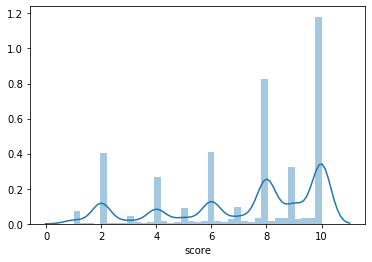

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.distplot(ytr)

plt.show()

############# RandomForestRegressor подготовка #############

In [17]:
ytr[:10]

66734      9.0
62376     10.0
78493      2.7
89276      1.0
73820     10.0
48015     10.0
41700      9.0
134363    10.0
109962     8.0
96023      9.2
Name: score, dtype: float64

In [18]:
from sklearn import utils
ytr1 = ytr.astype('int')
yval1 = yval.astype('int')
utils.multiclass.type_of_target(ytr1)

'multiclass'

In [19]:
ytr1[:10]

66734      9
62376     10
78493      2
89276      1
73820     10
48015     10
41700      9
134363    10
109962     8
96023      9
Name: score, dtype: int32

############# Catboost #############

In [20]:
from catboost import CatBoostRegressor

clf = CatBoostRegressor()

In [21]:
clf.fit(Xtr, ytr1)

Learning rate set to 0.072685
0:	learn: 2.7178702	total: 2.84s	remaining: 47m 16s
1:	learn: 2.6967147	total: 2.89s	remaining: 24m 4s
2:	learn: 2.6763535	total: 2.95s	remaining: 16m 21s
3:	learn: 2.6591767	total: 3s	remaining: 12m 27s
4:	learn: 2.6436460	total: 3.05s	remaining: 10m 6s
5:	learn: 2.6274974	total: 3.1s	remaining: 8m 34s
6:	learn: 2.6130342	total: 3.16s	remaining: 7m 28s
7:	learn: 2.6008861	total: 3.26s	remaining: 6m 44s
8:	learn: 2.5896289	total: 3.32s	remaining: 6m 5s
9:	learn: 2.5791901	total: 3.39s	remaining: 5m 35s
10:	learn: 2.5676830	total: 3.45s	remaining: 5m 9s
11:	learn: 2.5577011	total: 3.5s	remaining: 4m 48s
12:	learn: 2.5487504	total: 3.56s	remaining: 4m 30s
13:	learn: 2.5398791	total: 3.62s	remaining: 4m 14s
14:	learn: 2.5319254	total: 3.68s	remaining: 4m 1s
15:	learn: 2.5246580	total: 3.74s	remaining: 3m 50s
16:	learn: 2.5173866	total: 3.8s	remaining: 3m 39s
17:	learn: 2.5103606	total: 3.86s	remaining: 3m 30s
18:	learn: 2.5039617	total: 3.94s	remaining: 3m 23

159:	learn: 2.2296835	total: 12.3s	remaining: 1m 4s
160:	learn: 2.2287246	total: 12.4s	remaining: 1m 4s
161:	learn: 2.2275542	total: 12.5s	remaining: 1m 4s
162:	learn: 2.2264757	total: 12.5s	remaining: 1m 4s
163:	learn: 2.2253521	total: 12.6s	remaining: 1m 4s
164:	learn: 2.2241709	total: 12.6s	remaining: 1m 3s
165:	learn: 2.2231368	total: 12.7s	remaining: 1m 3s
166:	learn: 2.2218485	total: 12.8s	remaining: 1m 3s
167:	learn: 2.2205258	total: 12.8s	remaining: 1m 3s
168:	learn: 2.2196003	total: 12.9s	remaining: 1m 3s
169:	learn: 2.2182697	total: 12.9s	remaining: 1m 3s
170:	learn: 2.2170885	total: 13s	remaining: 1m 2s
171:	learn: 2.2158548	total: 13s	remaining: 1m 2s
172:	learn: 2.2146494	total: 13.1s	remaining: 1m 2s
173:	learn: 2.2134715	total: 13.2s	remaining: 1m 2s
174:	learn: 2.2121744	total: 13.2s	remaining: 1m 2s
175:	learn: 2.2112380	total: 13.3s	remaining: 1m 2s
176:	learn: 2.2100280	total: 13.3s	remaining: 1m 2s
177:	learn: 2.2091409	total: 13.4s	remaining: 1m 1s
178:	learn: 2.20

318:	learn: 2.0688457	total: 21.6s	remaining: 46.2s
319:	learn: 2.0679045	total: 21.7s	remaining: 46.1s
320:	learn: 2.0669516	total: 21.7s	remaining: 46s
321:	learn: 2.0660690	total: 21.8s	remaining: 45.9s
322:	learn: 2.0653538	total: 21.9s	remaining: 45.8s
323:	learn: 2.0644492	total: 21.9s	remaining: 45.7s
324:	learn: 2.0636596	total: 22s	remaining: 45.6s
325:	learn: 2.0628969	total: 22s	remaining: 45.5s
326:	learn: 2.0621300	total: 22.1s	remaining: 45.4s
327:	learn: 2.0612469	total: 22.1s	remaining: 45.3s
328:	learn: 2.0607186	total: 22.2s	remaining: 45.2s
329:	learn: 2.0597336	total: 22.2s	remaining: 45.1s
330:	learn: 2.0590152	total: 22.3s	remaining: 45s
331:	learn: 2.0581548	total: 22.3s	remaining: 44.9s
332:	learn: 2.0572429	total: 22.4s	remaining: 44.9s
333:	learn: 2.0564382	total: 22.5s	remaining: 44.8s
334:	learn: 2.0555041	total: 22.6s	remaining: 44.8s
335:	learn: 2.0546198	total: 22.6s	remaining: 44.7s
336:	learn: 2.0536998	total: 22.7s	remaining: 44.6s
337:	learn: 2.052856

479:	learn: 1.9417543	total: 32.3s	remaining: 34.9s
480:	learn: 1.9410668	total: 32.3s	remaining: 34.9s
481:	learn: 1.9403960	total: 32.4s	remaining: 34.8s
482:	learn: 1.9398826	total: 32.5s	remaining: 34.8s
483:	learn: 1.9390422	total: 32.6s	remaining: 34.7s
484:	learn: 1.9383423	total: 32.6s	remaining: 34.7s
485:	learn: 1.9377052	total: 32.7s	remaining: 34.6s
486:	learn: 1.9369970	total: 32.8s	remaining: 34.5s
487:	learn: 1.9362801	total: 32.9s	remaining: 34.5s
488:	learn: 1.9357315	total: 32.9s	remaining: 34.4s
489:	learn: 1.9350613	total: 33s	remaining: 34.3s
490:	learn: 1.9342928	total: 33.1s	remaining: 34.3s
491:	learn: 1.9337680	total: 33.1s	remaining: 34.2s
492:	learn: 1.9331499	total: 33.2s	remaining: 34.1s
493:	learn: 1.9322930	total: 33.3s	remaining: 34.1s
494:	learn: 1.9316163	total: 33.3s	remaining: 34s
495:	learn: 1.9309276	total: 33.4s	remaining: 34s
496:	learn: 1.9300759	total: 33.5s	remaining: 33.9s
497:	learn: 1.9292798	total: 33.6s	remaining: 33.9s
498:	learn: 1.9285

639:	learn: 1.8346583	total: 42.8s	remaining: 24.1s
640:	learn: 1.8342347	total: 42.9s	remaining: 24s
641:	learn: 1.8336838	total: 42.9s	remaining: 23.9s
642:	learn: 1.8330986	total: 43s	remaining: 23.9s
643:	learn: 1.8325046	total: 43.1s	remaining: 23.8s
644:	learn: 1.8319198	total: 43.1s	remaining: 23.7s
645:	learn: 1.8312160	total: 43.2s	remaining: 23.7s
646:	learn: 1.8305311	total: 43.2s	remaining: 23.6s
647:	learn: 1.8297642	total: 43.3s	remaining: 23.5s
648:	learn: 1.8290368	total: 43.4s	remaining: 23.4s
649:	learn: 1.8284642	total: 43.4s	remaining: 23.4s
650:	learn: 1.8278885	total: 43.5s	remaining: 23.3s
651:	learn: 1.8273490	total: 43.5s	remaining: 23.2s
652:	learn: 1.8266646	total: 43.6s	remaining: 23.2s
653:	learn: 1.8260396	total: 43.6s	remaining: 23.1s
654:	learn: 1.8253789	total: 43.7s	remaining: 23s
655:	learn: 1.8249591	total: 43.8s	remaining: 22.9s
656:	learn: 1.8243529	total: 43.8s	remaining: 22.9s
657:	learn: 1.8238325	total: 43.9s	remaining: 22.8s
658:	learn: 1.8231

800:	learn: 1.7374835	total: 52.9s	remaining: 13.1s
801:	learn: 1.7368746	total: 52.9s	remaining: 13.1s
802:	learn: 1.7362689	total: 53s	remaining: 13s
803:	learn: 1.7356036	total: 53.1s	remaining: 12.9s
804:	learn: 1.7350461	total: 53.1s	remaining: 12.9s
805:	learn: 1.7344178	total: 53.2s	remaining: 12.8s
806:	learn: 1.7337078	total: 53.2s	remaining: 12.7s
807:	learn: 1.7332219	total: 53.3s	remaining: 12.7s
808:	learn: 1.7326455	total: 53.4s	remaining: 12.6s
809:	learn: 1.7322372	total: 53.4s	remaining: 12.5s
810:	learn: 1.7316443	total: 53.5s	remaining: 12.5s
811:	learn: 1.7310798	total: 53.5s	remaining: 12.4s
812:	learn: 1.7304425	total: 53.6s	remaining: 12.3s
813:	learn: 1.7300484	total: 53.7s	remaining: 12.3s
814:	learn: 1.7294601	total: 53.7s	remaining: 12.2s
815:	learn: 1.7288003	total: 53.8s	remaining: 12.1s
816:	learn: 1.7282537	total: 53.9s	remaining: 12.1s
817:	learn: 1.7276735	total: 54s	remaining: 12s
818:	learn: 1.7270234	total: 54.1s	remaining: 11.9s
819:	learn: 1.726534

962:	learn: 1.6491411	total: 1m 3s	remaining: 2.44s
963:	learn: 1.6485787	total: 1m 3s	remaining: 2.37s
964:	learn: 1.6480575	total: 1m 3s	remaining: 2.31s
965:	learn: 1.6474288	total: 1m 3s	remaining: 2.24s
966:	learn: 1.6469181	total: 1m 3s	remaining: 2.17s
967:	learn: 1.6463027	total: 1m 3s	remaining: 2.11s
968:	learn: 1.6458680	total: 1m 3s	remaining: 2.04s
969:	learn: 1.6453160	total: 1m 3s	remaining: 1.98s
970:	learn: 1.6448796	total: 1m 3s	remaining: 1.91s
971:	learn: 1.6443137	total: 1m 4s	remaining: 1.84s
972:	learn: 1.6438219	total: 1m 4s	remaining: 1.78s
973:	learn: 1.6431745	total: 1m 4s	remaining: 1.71s
974:	learn: 1.6426783	total: 1m 4s	remaining: 1.65s
975:	learn: 1.6422930	total: 1m 4s	remaining: 1.58s
976:	learn: 1.6418913	total: 1m 4s	remaining: 1.51s
977:	learn: 1.6413737	total: 1m 4s	remaining: 1.45s
978:	learn: 1.6408104	total: 1m 4s	remaining: 1.38s
979:	learn: 1.6403548	total: 1m 4s	remaining: 1.32s
980:	learn: 1.6399667	total: 1m 4s	remaining: 1.25s
981:	learn: 

In [22]:
clf.score(Xval, yval1)

0.3278618410128077

In [23]:
y_pred_val = clf.predict(Xval)

In [24]:
df = pd.DataFrame(list(zip(y_pred_val, yval)),
                                 columns = ['y_pred_val', 'yval'])
df.head(30)

,y_pred_val,yval
0,7.596099,8.0
1,9.032968,5.8
2,7.157355,6.0
3,7.704176,6.0
4,8.313011,9.0
5,5.851508,4.0
6,7.327953,10.0
7,6.661579,8.0
8,8.836410,10.0
9,7.107295,7.0
